In [15]:
import tensorflow as tf
import os
import imageio
import csv
import numpy as np
import cv2
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score
from PIL import Image
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from scipy.ndimage import gaussian_filter
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from skimage import measure

In [14]:
pip install -U scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 11.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.9/222.9 kB 9.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [10]:
def process_mask(mask):
    # Thresholding (Otsu's method)

    mask = mask.astype(np.uint8)
    _, binary_mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Morphological operations
    kernel = np.ones((2, 2), np.uint8)

    # Binary dilation
    dilated_mask = cv2.dilate(binary_mask, kernel, iterations=1)

    # Border clearing
    cleared_mask = dilated_mask.copy()
    contours, _ = cv2.findContours(cleared_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(cleared_mask, contours, -1, 1, thickness=cv2.FILLED)

    largest_contour = max(contours, key=cv2.contourArea)

    middle_part_mask = np.zeros_like(cleared_mask)
    cv2.drawContours(middle_part_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

    smoothed_mask = cv2.erode(middle_part_mask, kernel, iterations=1)
    smoothed_mask = gaussian_filter(smoothed_mask.astype(float), sigma=1)
    cleared_mask = smoothed_mask

    # Small object removal
    cleared_mask = cv2.morphologyEx(cleared_mask, cv2.MORPH_OPEN, kernel)

    # Hole-filling within the lesion masks
    cleared_mask = cv2.morphologyEx(cleared_mask, cv2.MORPH_CLOSE, kernel)

    return cleared_mask.astype(np.uint8)

In [9]:
def circularity_f(processed_mask):
    label_image = measure.label(processed_mask, connectivity=2)
    properties = measure.regionprops(label_image)
    largest_region = max(properties, key=lambda x: x.area)
    circularity = 4 * np.pi * largest_region.area / (largest_region.perimeter ** 2)
    return circularity

In [5]:
original_image = np.reshape(image_1d[7], target_size)
processed_mask = process_mask(original_image)

final_masked_image = cv2.bitwise_and(original_image,original_image,mask=processed_mask)

# Compute the standard deviation of the intensity distribution for each lesion
std_deviation = np.std(final_masked_image)

# Use region props to obtain the circularity of each mask
label_image = measure.label(processed_mask, connectivity=2)

properties = measure.regionprops(label_image)
largest_region = max(properties, key=lambda x: x.area)

# Calculate circularity for the largest region
circularity = 4 * np.pi * largest_region.area / (largest_region.perimeter ** 2)

print(f"Lesion Circularity: {circularity}")


plt.subplot(1, 3, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Processed Mask')

# Display the original image
plt.subplot(1, 3, 2)
plt.imshow(final_masked_image, cmap='gray')
plt.title('Original Image')

# Display the processed mask
plt.subplot(1, 3, 3)
plt.imshow(processed_mask, cmap='gray')
plt.title('Processed Mask')

plt.show()

NameError: name 'image_1d' is not defined

Unique Labels: [0 1]


In [216]:
split_ratio = 0.7
# Get the total number of samples
num_samples = tf.shape(class_tensor_encoded)[0]

num_train_samples = tf.cast(tf.floor(split_ratio * tf.cast(num_samples, tf.float32)), tf.int32)
num_test_samples = num_samples - num_train_samples

# Generate random indices for shuffling
indices = tf.range(num_samples)
shuffled_indices = tf.random.shuffle(indices)

# Split the indices into training and testing sets
train_indices = shuffled_indices[:num_train_samples]
test_indices = shuffled_indices[num_train_samples:]

# Use tf.gather to get the training and testing sets
X_train = tf.gather(filtered_values, train_indices)
y_train = tf.gather(class_tensor_encoded, train_indices)
circularity_test = tf.gather(circularity_tensor,test_indices)
X_test = tf.gather(filtered_values, test_indices)
y_test = tf.gather(class_tensor_encoded, test_indices)

In [7]:
working_directory_test = "/Users/matheusss03/Developer/appDosGuri/test"
working_directory_train = "/Users/matheusss03/Developer/appDosGuri/training"

In [17]:
# Set your parameters
target_size = (100, 100)
batch_size = 50
consistent_length = None
image_tensors = []
circularity_tensors = []

image_files = [f for f in os.listdir(working_directory_train) if f.endswith('.JPG')]
size = len(image_files)

for i in range(0, len(image_files), batch_size):
    batch = image_files[i:i + batch_size]
    print(i)
    batch_images = []
    circularity_vector = []

    for file in batch:
        image = Image.open(os.path.join(working_directory_train, file))
        resized_image_array = tf.keras.preprocessing.image.img_to_array(image)
        gray_image = 255 - resized_image_array.mean(axis=2).astype('int32')
        processed_mask = process_mask(gray_image)
        final_masked_image = cv2.bitwise_and(gray_image,gray_image,mask=processed_mask)
        final_masked_resized = cv2.resize(final_masked_image.astype('uint8'), target_size)
        batch_images.append(final_masked_resized)
        circularity_vector.append(circularity_f(processed_mask))
        

    # Convert the batch of images to a tensor
    batch_tensor = np.stack(batch_images, axis=0)
    batch_circularity = np.stack(circularity_vector, axis=0)
    image_tensors.append(batch_tensor)
    circularity_tensors.append(batch_circularity)
    
# Stack the list of tensors to create the final tensor
final_tensor = np.vstack(image_tensors)
final_circularity = np.vstack(circularity_tensors)
filtered_circularity_tensor = final_circularity[filter_condition]
filtered_tensor1 = final_tensor[filter_condition]


0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350
9400
9450
9500
9550
9600
9650
9700
9750
9800
9850
9900
9950
10000


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 50 and the array at index 200 has size 15

In [ ]:
image_tensors_test = []
circularity_tensors_test = []

image_files_test = [f for f in os.listdir(working_directory_test) if f.endswith('.JPG')]
size = len(image_files)

for i in range(0, len(image_files_test), batch_size):
    batch_test = image_files_test[i:i + batch_size]
    print(i)
    batch_images_test = []
    circularity_vector_test = []

    for file in batch:
        image_test = Image.open(os.path.join(working_directory_test, file_test))
        resized_image_array_test = tf.keras.preprocessing.image.img_to_array(image_test)
        gray_image_test = 255 - resized_image_array_test.mean(axis=2).astype('int32')
        processed_mask_test = process_mask(gray_image_test)
        final_masked_image_test = cv2.bitwise_and(gray_image_test,gray_image_test,mask=processed_mask_test)
        final_masked_resized_test = cv2.resize(final_masked_image_test.astype('uint8'), target_size)
        batch_images_test.append(final_masked_resized_test)
        circularity_vector_test.append(circularity_f(processed_mask_test))
        

    # Convert the batch of images to a tensor
    batch_tensor_test = np.stack(batch_images_test, axis=0)
    batch_cirularity_test = np.stack(circularity_vector_test, axis=0)
    image_tensors_test.append(batch_tensor_test)
    circularity_tensors_test.append(batch_circularity_test)
    
# Stack the list of tensors to create the final tensor
final_tensor_test = np.vstack(image_tensors_test)
final_circularity_test = np.vstack(circularity_tensors_test)
filtered_circularity_tensor_test = final_circularity[filter_condition_test]
filtered_tensor1_test = final_tensor[filter_condition_test]

In [ ]:
## Opens the excel file and creates a tensor of the classes

with open("challenge-2016-training_metadata_2023-11-04.csv", mode='r') as file:
    csv_reader = csv.reader(file)
    header = next(csv_reader)
    age_column_index = header.index("benign_malignant")
    age_data = [row[age_column_index] for row in csv_reader]

image_vectors_tensor = tf.stack(image_1d)

label_encoder = LabelEncoder()
class_tensor_np = np.array(age_data) 

desired_classes = ['benign', 'malignant']
filter_condition = np.isin(age_data, desired_classes)

filtered_values = image_vectors_tensor[filter_condition]
filtered_classes = class_tensor_np[filter_condition]

circularity_vector1 = np.array(circularity_vector)
circularity_vector_filtered = circularity_vector1[filter_condition]
circularity_tensor = tf.constant(circularity_vector_filtered)


class_tensor_encoded_np = label_encoder.fit_transform(filtered_classes)
class_tensor_encoded = tf.constant(class_tensor_encoded_np, dtype=tf.int32)

In [ ]:
## Opens the excel file and creates a tensor of the classes for the test images

with open("challenge-2016-training_metadata_2023-11-04.csv", mode='r') as file:
    csv_reader_test = csv.reader(file)
    header_test = next(csv_reader_test)
    age_column_index_test = header_test.index("benign_malignant")
    age_data_test = [row[age_column_index_test] for row in csv_reader_test]

image_vectors_tensor_test = tf.stack(image_1d_test)

label_encoder_test = LabelEncoder()
class_tensor_np_test = np.array(age_data_test) 

desired_classes = ['benign', 'malignant']
filter_condition_test = np.isin(age_data_test, desired_classes)

filtered_values_test = image_vectors_tensor_test[filter_condition_test]
filtered_classes_test = class_tensor_np_test[filter_condition_test]

circularity_vector1_test = np.array(circularity_vector_test)
circularity_vector_filtered_test = circularity_vector1_test[filter_condition_test]
circularity_tensor_test = tf.constant(circularity_vector_filtered_test)


class_tensor_encoded_np_test = label_encoder_test.fit_transform(filtered_classes_test)
class_tensor_encoded_test = tf.constant(class_tensor_encoded_np_test, dtype=tf.int32)

In [386]:
dataset1 = tf.data.Dataset.from_tensor_slices((filtered_tensor1, class_tensor_encoded))

split_ratio = 0.7
# Get the total number of samples
num_samples = tf.shape(class_tensor_encoded)[0]

num_train_samples = tf.cast(tf.floor(split_ratio * tf.cast(num_samples, tf.float32)), tf.int32)
num_test_samples = num_samples - num_train_samples

# Generate random indices for shuffling
indices = tf.range(num_samples)
shuffled_indices = tf.random.shuffle(indices)

# Split the indices into training and testing sets
train_indices = shuffled_indices[:num_train_samples]
test_indices = shuffled_indices[num_train_samples:]

# Use tf.gather to get the training and testing sets
X_train1 = tf.gather(filtered_tensor1, train_indices)
y_train = tf.gather(class_tensor_encoded, train_indices)

X_test1 = tf.gather(filtered_tensor1, test_indices)

y_test = tf.gather(class_tensor_encoded, test_indices)


In [387]:
input_shape = (100, 100, 1)

model1 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    layers.Dropout(dropout),
    layers.Dense(2, activation='softmax')  # Binary classification, use 'softmax' for multi-class
])

# Compile the model
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
model1.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model1.fit(X_train1, y_train, epochs=30, batch_size=batch_size, validation_split=0.2)

# Evaluate the model on the test data
loss, accuracy = model1.evaluate(X_test1, y_test)

Epoch 1/30
10/10 [==============================] - 6s 417ms/step - loss: 9.6781 - accuracy: 0.6580 - val_loss: 2.0138 - val_accuracy: 0.7698
Epoch 2/30
10/10 [==============================] - 4s 367ms/step - loss: 1.9031 - accuracy: 0.7120 - val_loss: 1.6169 - val_accuracy: 0.7540
Epoch 3/30
10/10 [==============================] - 4s 371ms/step - loss: 1.5679 - accuracy: 0.7860 - val_loss: 1.6582 - val_accuracy: 0.7778
Epoch 4/30
10/10 [==============================] - 4s 364ms/step - loss: 1.4021 - accuracy: 0.8160 - val_loss: 1.5473 - val_accuracy: 0.7698
Epoch 5/30
10/10 [==============================] - 4s 363ms/step - loss: 1.3288 - accuracy: 0.8760 - val_loss: 1.5461 - val_accuracy: 0.7698
Epoch 6/30
10/10 [==============================] - 4s 378ms/step - loss: 1.3101 - accuracy: 0.8820 - val_loss: 1.5553 - val_accuracy: 0.7778
Epoch 7/30
10/10 [==============================] - 4s 453ms/step - loss: 1.2515 - accuracy: 0.9200 - val_loss: 1.5522 - val_accuracy: 0.7857
Epoch 

In [388]:
y_pred_prob = model1.predict(X_test1)

# Convert predicted probabilities to predicted labels
y_pred_labels = np.argmax(y_pred_prob, axis = 1)

# Convert one-hot encoded true labels to integer labels
y_true_labels = np.array(y_test)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

precision = precision_score(y_true_labels, y_pred_labels)
recall = recall_score(y_true_labels, y_pred_labels)
f1 = f1_score(y_true_labels, y_pred_labels)

print(f1,recall,precision)
float_tensor = tf.cast(X_test1, tf.float32)
std_deviation = tf.math.reduce_std(float_tensor, axis=[1, 2])
concatenated_vector = np.column_stack((y_pred_prob,circularity_test,std_deviation))

9/9 [==============================] - 1s 51ms/step
Confusion Matrix:
[[213   7]
 [ 45   4]]
0.13333333333333333 0.08163265306122448 0.36363636363636365


In [266]:
kmeans = KMeans(n_clusters=2)

# Fit the KMeans model to the data
kmeans.fit(concatenated_vector)

# Get cluster labels and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
comparing = np.column_stack((y_true_labels,labels))

c:\Users\rodri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [267]:
from sklearn.metrics import normalized_mutual_info_score

# Assuming 'true_labels' is your ground truth vector and 'predicted_labels' is the K-Means cluster assignments
nmi = normalized_mutual_info_score(y_true_labels, labels)
print("Normalized Mutual Information:", nmi)

Normalized Mutual Information: 0.013712871271838067


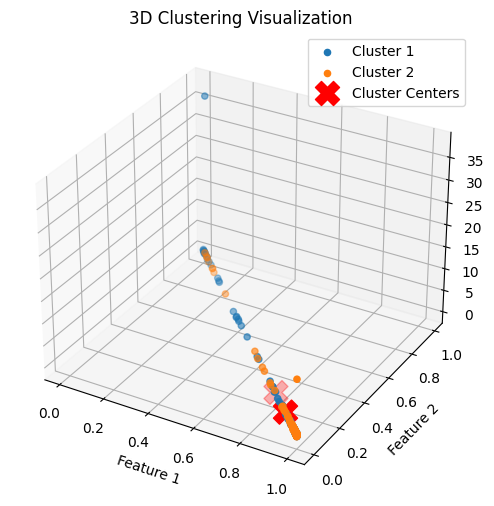

In [268]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each cluster
for i in range(kmeans.n_clusters):
    ax.scatter(concatenated_vector[labels == i, 0], concatenated_vector[labels == i, 1], concatenated_vector[labels == i, 2], label=f'Cluster {i + 1}')

# Plot cluster centers
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2],
           s=300, c='red', marker='X', label='Cluster Centers')

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.set_title('3D Clustering Visualization')
ax.legend()

plt.show()

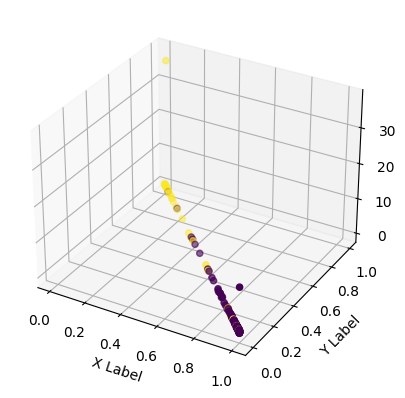

In [269]:
x = concatenated_vector[:, 0]
y = concatenated_vector[:, 1]
z = concatenated_vector[:, 2]

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=y_true_labels, marker='o')

# Set axis labels
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Show the plot
plt.show()

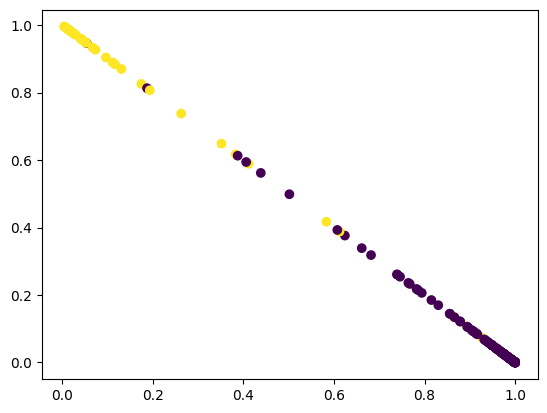

In [348]:

x = concatenated_vector[:, 0]
z = concatenated_vector[:, 1]

# Create a 3D scatter plot

plt.scatter(x, z, c=y_true_labels, marker='o')
plt.show()

In [389]:
tetha1 = 0.01
tetha2 = 30

pred_f = []

for s in concatenated_vector:
    
    if s[1] > tetha1 and s[3] > tetha2 and s[1] < 0.9999:
        pred_f += [1]
 
    else:
        pred_f += [0]

conf_matrix_f = confusion_matrix(y_true_labels, pred_f)
conc = np.column_stack((y_true_labels,pred_f))

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix_f)
precision = precision_score(y_true_labels, pred_f)
print(precision)

Confusion Matrix:
[[105 115]
 [ 20  29]]
0.2013888888888889
